In [27]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [29]:
tf.keras.backend.clear_session()

In [30]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [31]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [32]:
subject = 'Rondônia - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [33]:
data = pd.read_csv('2003_mo_model_input_RO.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Rondônia - Consumo de Cimento (t),Rondônia - Desemprego
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,4.987000,0.688843,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,13.867,8.226062
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,4.987000,0.689031,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,10.777,8.219943
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,4.987000,0.689218,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,13.888,8.213823
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,4.987000,0.689405,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,11.859,8.207703
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,4.987000,0.689592,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,14.431,8.201584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.931530,NaN,NaN,NaN,NaN,NaN,49.066,NaN
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.812259,NaN,NaN,NaN,NaN,NaN,49.850,NaN
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.687985,NaN,NaN,NaN,NaN,NaN,43.733,NaN
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.551024,NaN,NaN,NaN,NaN,NaN,40.078,NaN


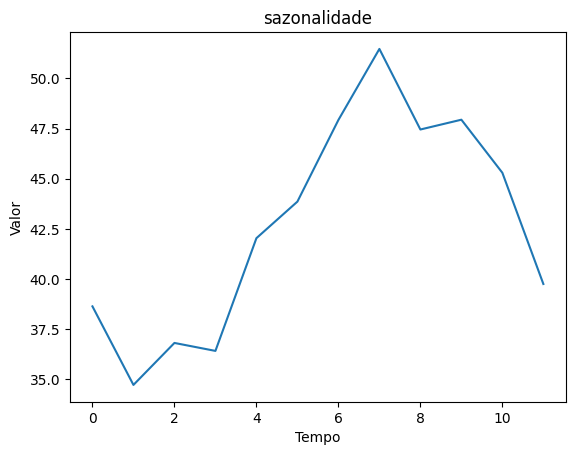

,sazonalidade
sazonalidade,
0,38.640150
1,34.725400
2,36.817425
3,36.420650
4,42.038250
5,43.860500
6,47.928850
7,51.469600
8,47.453850


In [34]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [35]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Rondônia - Desemprego,sazonalidade,Rondônia - Consumo de Cimento (t)
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,4.987000,0.688843,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,8.226062,38.640150,13.867
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,4.987000,0.689031,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,8.219943,34.725400,10.777
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,4.987000,0.689218,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,8.213823,36.817425,13.888
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,4.987000,0.689405,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,8.207703,36.420650,11.859
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,4.987000,0.689592,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,8.201584,42.038250,14.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.931530,NaN,NaN,NaN,NaN,NaN,NaN,51.469600,49.066
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.812259,NaN,NaN,NaN,NaN,NaN,NaN,47.453850,49.850
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.687985,NaN,NaN,NaN,NaN,NaN,NaN,47.942450,43.733
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.551024,NaN,NaN,NaN,NaN,NaN,NaN,45.296950,40.078


In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      21.211
1      15.823
2      15.195
3      15.479
4      18.536
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Rondônia - Consumo de Cimento (t), Length: 240, dtype: float64

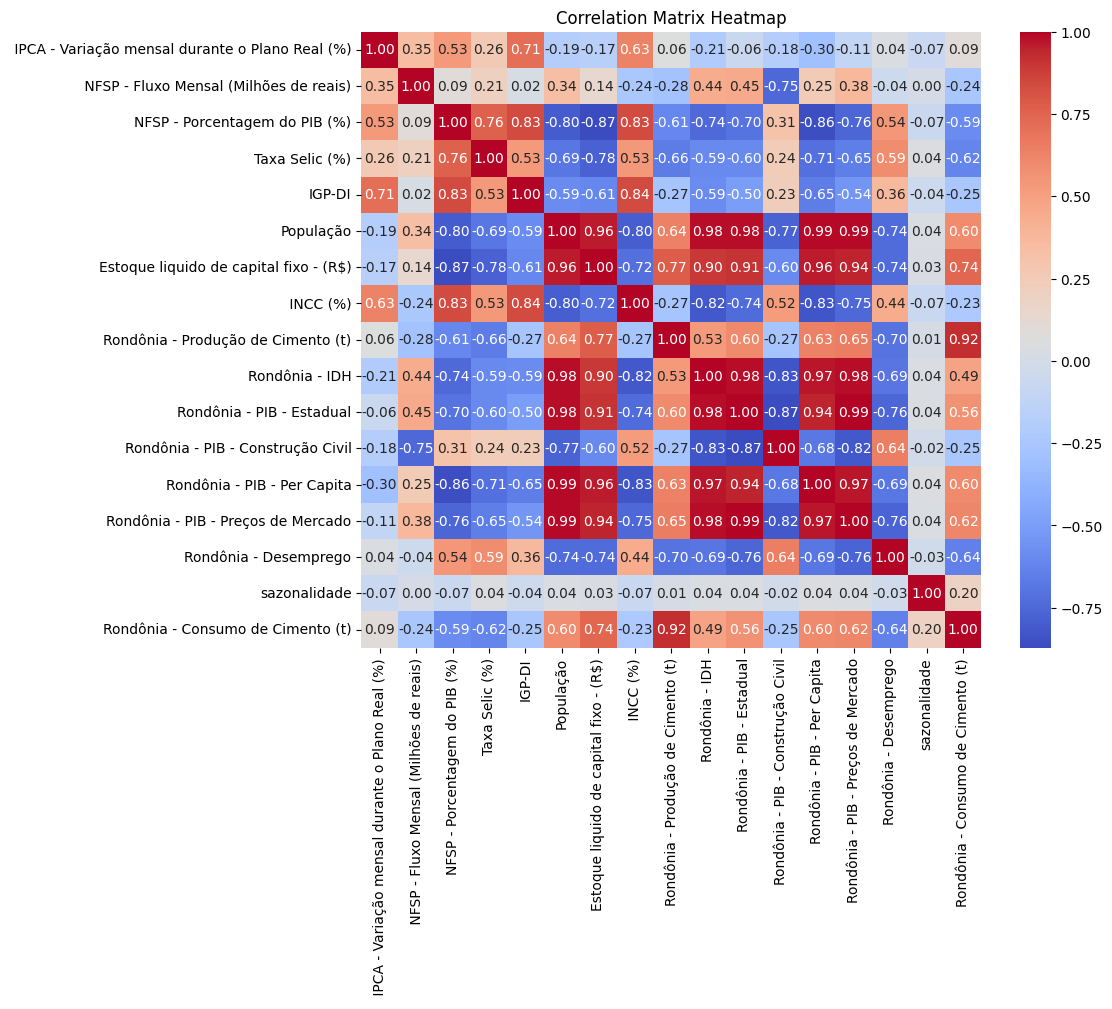

In [37]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [39]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,IPCA - Variação mensal durante o Plano Real (%),1.091838e+03
1,NFSP - Fluxo Mensal (Milhões de reais),2.493156e+02
2,NFSP - Porcentagem do PIB (%),1.855571e+02
3,Taxa Selic (%),5.610255e+01
4,IGP-DI,2.351741e+02
5,População,1.797880e+06
6,Estoque liquido de capital fixo - (R$),6.831948e+05
7,INCC (%),7.089877e+02
8,Rondônia - Produção de Cimento (t),2.225610e+02
9,Rondônia - IDH,3.886029e+06


In [40]:
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 1


,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - Desemprego,sazonalidade
0,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,4.987000,0.688843,2.068350e+07,1.587672e+06,11.468162,8.226062,38.640150
1,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,4.987000,0.689031,2.071062e+07,1.589518e+06,11.472453,8.219943,34.725400
2,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,4.987000,0.689218,2.073774e+07,1.591364e+06,11.476744,8.213823,36.817425
3,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,4.987000,0.689405,2.076486e+07,1.593210e+06,11.481034,8.207703,36.420650
4,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,4.987000,0.689592,2.079198e+07,1.595056e+06,11.485325,8.201584,42.038250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,18.811821,0.714578,2.512984e+07,1.460038e+06,11.831960,7.206312,51.469600
176,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,18.689723,0.714532,2.512400e+07,1.460807e+06,11.831498,7.195485,47.453850
177,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,18.542721,0.714486,2.511815e+07,1.461577e+06,11.831036,7.184659,47.942450
178,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,18.336632,0.714440,2.511231e+07,1.462346e+06,11.830574,7.173832,45.296950


In [41]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - Desemprego
0,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.098891,-1.823039,-1.632278,0.283496,-2.350850,1.189771
1,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.098891,-1.798540,-1.614104,0.308885,-2.307809,1.176245
2,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.098891,-1.774041,-1.595929,0.334273,-2.264769,1.162719
3,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.098891,-1.749542,-1.577755,0.359661,-2.221729,1.149193
4,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.098891,-1.725043,-1.559580,0.385049,-2.178689,1.135667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.425789,-0.584804,-1.503380,-0.514871,1.368581,0.605679,-1.872446,-0.216507,1.544497,1.347401,-1.471890,1.298474,-1.064141
176,0.339575,-0.580461,-0.733634,-0.473208,1.380202,0.591420,-1.876611,-0.224300,1.538451,1.343485,-1.461306,1.293839,-1.088071
177,0.160702,-0.571531,-0.323353,-0.484199,1.391823,0.577161,-1.875135,-0.233683,1.532406,1.339569,-1.450723,1.289204,-1.112000
178,0.244264,-0.555524,0.132757,-0.359568,1.403443,0.562902,-1.942040,-0.246837,1.526361,1.335653,-1.440140,1.284569,-1.135929


In [42]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - Desemprego
0,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.098891,-1.823039,-1.632278,0.283496,-2.350850,1.189771
1,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.098891,-1.798540,-1.614104,0.308885,-2.307809,1.176245
2,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.098891,-1.774041,-1.595929,0.334273,-2.264769,1.162719
3,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.098891,-1.749542,-1.577755,0.359661,-2.221729,1.149193
4,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.098891,-1.725043,-1.559580,0.385049,-2.178689,1.135667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.465326,-0.676734,0.472779,-1.087000,1.228701,0.759879,-1.491033,-0.161674,1.587260,1.348174,-1.572438,1.232992,-0.563646
164,1.351131,-0.668750,0.302784,-0.904679,1.240408,0.749001,-1.525186,-0.158941,1.587171,1.353501,-1.567145,1.252578,-0.630244
165,1.143146,-0.657609,0.339539,-0.900134,1.252114,0.738124,-1.546744,-0.157096,1.587081,1.358829,-1.561852,1.272164,-0.696842
166,1.542609,-0.647588,0.472795,-1.136836,1.263821,0.727246,-1.586381,-0.161536,1.586992,1.364157,-1.556559,1.291749,-0.763439


In [43]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      21.211
1      15.823
2      15.195
3      15.479
4      18.536
        ...  
163    39.293
164    41.610
165    43.544
166    35.658
167    29.693
Name: Rondônia - Consumo de Cimento (t), Length: 168, dtype: float64

In [44]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [45]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 13)

In [46]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - Desemprego
132,0.817451,-0.366715,-0.530011,0.174628,0.848407,0.965586,-0.066954,0.718677,0.678933,0.983681,-0.991059,0.648927,-0.885224
133,1.130195,-0.350285,-0.532694,0.240832,0.861179,0.962419,-0.130652,0.671074,0.693440,0.999476,-1.023932,0.666384,-0.817584
134,1.160498,-0.335122,-0.186421,0.176857,0.873950,0.959252,-0.079602,0.631009,0.707946,1.015272,-1.056805,0.683841,-0.749944
135,1.131990,-0.321950,-0.719664,-0.005233,0.886722,0.956085,-0.034473,0.590391,0.722453,1.031067,-1.089678,0.701298,-0.682304
136,1.384387,-0.302995,-0.798520,0.097576,0.899493,0.952918,-0.177535,0.548958,0.736959,1.046862,-1.122551,0.718755,-0.614664
137,1.375487,-0.290554,-0.612129,0.431487,0.912265,0.949751,-0.208868,0.506886,0.751466,1.062657,-1.155424,0.736212,-0.547024
138,1.438928,-0.281926,-0.476740,0.482414,0.925036,0.946584,-0.245300,0.464614,0.765972,1.078452,-1.188297,0.753669,-0.479384
139,1.569590,-0.275931,-0.211736,0.657043,0.937808,0.943417,-0.333490,0.422280,0.780479,1.094247,-1.221170,0.771126,-0.411744
140,1.584058,-0.271466,-0.484608,0.678386,0.950580,0.940250,-0.296846,0.380004,0.794985,1.110042,-1.254043,0.788584,-0.344104
141,1.166380,-0.273241,-0.183907,0.727143,0.963351,0.937082,-0.292462,0.338080,0.809492,1.125837,-1.286916,0.806041,-0.276464


In [47]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 13)

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(72, activation='tanh',
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    mape = np.mean(df_results["Error"])/np.mean(df_results["Target"])

    return df_results, predictions, mape

In [51]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions, mape = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(f"\n\Results: {i} ___________________________________________\n")
            display(df_results.T)
            display(mape)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [52]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[3853451199, 2229359158, 420677989, 2544153098, 150246374, 1372923463, 2419303316, 1522031456, 3596268421, 3140884288]


Step: 0 ___________________________________________
val_loss: 62.29262924194336
winner_seed: 3853451199


Step: 1 ___________________________________________
val_loss: 58.711273193359375
winner_seed: 2229359158


Step: 2 ___________________________________________
val_loss: 59.11365509033203


Step: 3 ___________________________________________
val_loss: 56.5838508605957
winner_seed: 2544153098


Step: 4 ___________________________________________
val_loss: 59.63405227661133


Step: 5 ___________________________________________
val_loss: 55.773895263671875
winner_seed: 1372923463


Step: 6 ___________________________________________
val_loss: 55.8923225402832


Step: 7 ___________________________________________
val_loss: 69.40703582763672


Step: 8 ___________________________________________
val_loss: 58.291175842285156


Step: 9 ____________________________________

'\n\\Results: 0 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,32.072426,31.078886,30.572346,30.077301,29.40206,28.816116,28.727757,29.099569,27.821522,28.360325,28.821301,29.352634
Target,32.559,24.91,28.713,32.66,31.635,35.142,36.419,40.3,35.493,38.489,35.591,27.53
Error,0.486572,6.168886,1.859346,2.582699,2.232941,6.325882,7.691242,11.20043,7.671478,10.128674,6.769699,1.822634


0.16257841106261434

[2550018893, 3269097685, 316493318, 753736473, 4214166670, 4083691649, 843730364, 1233009500, 158024002, 413386560]


Step: 0 ___________________________________________
val_loss: 60.4953498840332
winner_seed: 2550018893


Step: 1 ___________________________________________
val_loss: 64.75138092041016


Step: 2 ___________________________________________
val_loss: 48.35841751098633
winner_seed: 316493318


Step: 3 ___________________________________________
val_loss: 85.82545471191406


Step: 4 ___________________________________________
val_loss: 54.5150260925293


Step: 5 ___________________________________________
val_loss: 50.79446792602539


Step: 6 ___________________________________________
val_loss: 55.495399475097656


Step: 7 ___________________________________________
val_loss: 51.976722717285156


Step: 8 ___________________________________________
val_loss: 58.064178466796875


Step: 9 ___________________________________________
val_loss: 65.56455993652344
1/1 [===========

'\n\\Results: 1 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,32.915264,32.900791,32.597996,32.537735,32.258511,31.962282,31.951229,32.033276,31.780645,31.880001,31.981575,32.077911
Target,32.559,24.91,28.713,32.66,31.635,35.142,36.419,40.3,35.493,38.489,35.591,27.53
Error,0.356266,7.990791,3.884996,0.122265,0.62351,3.179716,4.46777,8.266724,3.712355,6.608997,3.609425,4.547911


0.11859254955146867

[522835886, 2074011802, 3721942666, 2587827750, 1166404581, 228198259, 1006119850, 1038233058, 3779534820, 1999117966]


Step: 0 ___________________________________________
val_loss: 49.83854675292969
winner_seed: 522835886


Step: 1 ___________________________________________
val_loss: 56.28996276855469


Step: 2 ___________________________________________
val_loss: 58.2811393737793


Step: 3 ___________________________________________
val_loss: 82.78443145751953


Step: 4 ___________________________________________
val_loss: 57.46056365966797


Step: 5 ___________________________________________
val_loss: 60.21399688720703


Step: 6 ___________________________________________
val_loss: 38.75628662109375
winner_seed: 1006119850


Step: 7 ___________________________________________
val_loss: 56.42955780029297


Step: 8 ___________________________________________
val_loss: 58.91913986206055


Step: 9 ___________________________________________
val_loss: 74.27570343017578
1/1 [==========

'\n\\Results: 2 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,34.530342,34.742531,33.825691,33.696915,33.506386,33.281212,32.638885,33.784271,33.418663,33.162537,33.538078,33.6646
Target,32.559,24.91,28.713,32.66,31.635,35.142,36.419,40.3,35.493,38.489,35.591,27.53
Error,1.971344,9.832531,5.112692,1.036915,1.871386,1.860786,3.780113,6.515728,2.074337,5.326462,2.052921,6.1346


0.11909097110550865

[3029779032, 480958604, 246906693, 2958495336, 1699503309, 3100402513, 4143363119, 2850141166, 2551311165, 1723609797]


Step: 0 ___________________________________________
val_loss: 53.704925537109375
winner_seed: 3029779032


Step: 1 ___________________________________________
val_loss: 75.65235900878906


Step: 2 ___________________________________________
val_loss: 56.80615234375


Step: 3 ___________________________________________
val_loss: 66.3883056640625


Step: 4 ___________________________________________
val_loss: 71.83963012695312


Step: 5 ___________________________________________
val_loss: 64.11656188964844


Step: 6 ___________________________________________
val_loss: 56.0147705078125


Step: 7 ___________________________________________
val_loss: 61.41860580444336


Step: 8 ___________________________________________
val_loss: 67.27874755859375


Step: 9 ___________________________________________
val_loss: 66.24348449707031
1/1 [==============================] - 0s

'\n\\Results: 3 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,32.789009,31.994038,31.553209,31.341305,31.573391,31.163204,31.185257,31.984907,31.106064,30.86059,31.597853,32.063023
Target,32.559,24.91,28.713,32.66,31.635,35.142,36.419,40.3,35.493,38.489,35.591,27.53
Error,0.230011,7.084038,2.84021,1.318695,0.061609,3.978794,5.233742,8.315092,4.386936,7.628408,3.993147,4.533022


0.12418281137855977

[2581627129, 3957646552, 3343396008, 681413854, 2474966853, 2422356364, 813684147, 672637165, 3665099124, 54167840]


Step: 0 ___________________________________________
val_loss: 70.8915786743164
winner_seed: 2581627129


Step: 1 ___________________________________________
val_loss: 55.370849609375
winner_seed: 3957646552


Step: 2 ___________________________________________
val_loss: 59.906700134277344


Step: 3 ___________________________________________
val_loss: 65.57547760009766


Step: 4 ___________________________________________
val_loss: 86.50831604003906


Step: 5 ___________________________________________
val_loss: 59.52597427368164


Step: 6 ___________________________________________
val_loss: 55.21896743774414
winner_seed: 813684147


Step: 7 ___________________________________________
val_loss: 58.18320083618164


Step: 8 ___________________________________________
val_loss: 75.38015747070312


Step: 9 ___________________________________________
val_loss: 60.0247802734

'\n\\Results: 4 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,33.256596,33.034046,33.028881,32.983559,32.980644,32.784328,33.199673,32.827267,33.061211,33.110577,33.231068,33.28614
Target,32.559,24.91,28.713,32.66,31.635,35.142,36.419,40.3,35.493,38.489,35.591,27.53
Error,0.697598,8.124046,4.315882,0.323559,1.345644,2.35767,3.219326,7.472733,2.431789,5.378422,2.359932,5.75614


0.10961002433884755

[875145838, 1835520935, 2691301267, 4169391893, 705048568, 2030952297, 990984712, 1828702564, 3330944479, 2291909212]


Step: 0 ___________________________________________
val_loss: 58.21902084350586
winner_seed: 875145838


Step: 1 ___________________________________________
val_loss: 52.94284439086914
winner_seed: 1835520935


Step: 2 ___________________________________________
val_loss: 61.170745849609375


Step: 3 ___________________________________________
val_loss: 82.26495361328125


Step: 4 ___________________________________________
val_loss: 54.14216613769531


Step: 5 ___________________________________________
val_loss: 84.58167266845703


Step: 6 ___________________________________________
val_loss: 60.32246017456055


Step: 7 ___________________________________________
val_loss: 60.72169876098633


Step: 8 ___________________________________________
val_loss: 60.39915084838867


Step: 9 ___________________________________________
val_loss: 57.51726150512695
1/1 [=========

'\n\\Results: 5 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,33.051632,33.196808,31.588211,32.333157,31.799053,31.218246,30.313162,33.203228,31.075729,31.408754,32.055798,32.041161
Target,32.559,24.91,28.713,32.66,31.635,35.142,36.419,40.3,35.493,38.489,35.591,27.53
Error,0.492634,8.286808,2.875212,0.326843,0.164053,3.923752,6.105837,7.096771,4.417271,7.080244,3.535202,4.51116


0.12221025473522835

[2140806682, 2818992071, 2852399544, 61851074, 3657582073, 3947082117, 748356471, 2380178522, 896352324, 3729561179]


Step: 0 ___________________________________________
val_loss: 61.52039337158203
winner_seed: 2140806682


Step: 1 ___________________________________________
val_loss: 57.16065216064453
winner_seed: 2818992071


Step: 2 ___________________________________________
val_loss: 56.801727294921875
winner_seed: 2852399544


Step: 3 ___________________________________________
val_loss: 43.20881271362305
winner_seed: 61851074


Step: 4 ___________________________________________
val_loss: 62.0811653137207


Step: 5 ___________________________________________
val_loss: 56.01237869262695


Step: 6 ___________________________________________
val_loss: 56.1110954284668


Step: 7 ___________________________________________
val_loss: 63.273624420166016


Step: 8 ___________________________________________
val_loss: 53.84128189086914


Step: 9 _________________________________________

'\n\\Results: 6 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,33.795715,33.465275,33.202744,33.266174,33.152897,32.576569,32.971294,32.918026,31.592628,31.993385,32.85947,33.34214
Target,32.559,24.91,28.713,32.66,31.635,35.142,36.419,40.3,35.493,38.489,35.591,27.53
Error,1.236717,8.555275,4.489744,0.606174,1.517897,2.56543,3.447704,7.381973,3.900372,6.495613,2.731529,5.81214


0.12202195084720745

[2277752960, 1449094979, 2777119091, 2770073912, 490656325, 1473655940, 3324206800, 3804043854, 3233135274, 3798505984]


Step: 0 ___________________________________________
val_loss: 56.13742446899414
winner_seed: 2277752960


Step: 1 ___________________________________________
val_loss: 66.77651977539062


Step: 2 ___________________________________________
val_loss: 59.952232360839844


Step: 3 ___________________________________________
val_loss: 66.66478729248047


Step: 4 ___________________________________________
val_loss: 60.8475341796875


Step: 5 ___________________________________________
val_loss: 56.999210357666016


Step: 6 ___________________________________________
val_loss: 55.57206726074219
winner_seed: 3324206800


Step: 7 ___________________________________________
val_loss: 55.957763671875


Step: 8 ___________________________________________
val_loss: 55.8773078918457


Step: 9 ___________________________________________
val_loss: 60.182437896728516
1/1 [========

'\n\\Results: 7 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,30.659962,29.696728,28.264465,28.120165,27.964655,27.854813,27.251148,29.260679,28.127655,27.008533,27.976692,28.280693
Target,32.559,24.91,28.713,32.66,31.635,35.142,36.419,40.3,35.493,38.489,35.591,27.53
Error,1.899036,4.786728,0.448534,4.539835,3.670345,7.287186,9.16785,11.03932,7.365345,11.480465,7.614307,0.750692


0.17536919439307305

[3288546270, 978432250, 2601744945, 2093768626, 3200234385, 2683538249, 2625479969, 3537384257, 808316717, 2760254394]


Step: 0 ___________________________________________
val_loss: 58.174407958984375
winner_seed: 3288546270


Step: 1 ___________________________________________
val_loss: 54.79273223876953
winner_seed: 978432250


Step: 2 ___________________________________________
val_loss: 57.67158508300781


Step: 3 ___________________________________________
val_loss: 54.5239372253418
winner_seed: 2093768626


Step: 4 ___________________________________________
val_loss: 52.363033294677734
winner_seed: 3200234385


Step: 5 ___________________________________________
val_loss: 57.56745910644531


Step: 6 ___________________________________________
val_loss: 63.67249298095703


Step: 7 ___________________________________________
val_loss: 57.031455993652344


Step: 8 ___________________________________________
val_loss: 59.45991516113281


Step: 9 ____________________________________

'\n\\Results: 8 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,33.304016,31.562689,29.97436,29.986786,29.695244,29.05353,29.900936,30.23189,28.46279,28.273373,29.541594,30.705704
Target,32.559,24.91,28.713,32.66,31.635,35.142,36.419,40.3,35.493,38.489,35.591,27.53
Error,0.745018,6.652689,1.26136,2.673214,1.939756,6.088469,6.518063,10.06811,7.03021,10.215626,6.049406,3.175703


0.15626244510351903

[22018324, 4170028282, 1112227586, 3962814019, 3263600066, 2928519173, 3403480310, 2870525483, 2384119994, 1596825897]


Step: 0 ___________________________________________
val_loss: 56.17456817626953
winner_seed: 22018324


Step: 1 ___________________________________________
val_loss: 63.777137756347656


Step: 2 ___________________________________________
val_loss: 56.39328384399414


Step: 3 ___________________________________________
val_loss: 57.27832794189453


Step: 4 ___________________________________________
val_loss: 93.35255432128906


Step: 5 ___________________________________________
val_loss: 83.55259704589844


Step: 6 ___________________________________________
val_loss: 71.25106048583984


Step: 7 ___________________________________________
val_loss: 54.05188751220703
winner_seed: 2870525483


Step: 8 ___________________________________________
val_loss: 58.47632598876953


Step: 9 ___________________________________________
val_loss: 55.41246795654297
1/1 [=========

'\n\\Results: 9 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,33.681583,33.725922,33.816368,32.981037,32.619221,32.357388,31.65045,31.406752,31.832878,30.76173,30.814157,28.352539
Target,32.559,24.91,28.713,32.66,31.635,35.142,36.419,40.3,35.493,38.489,35.591,27.53
Error,1.122585,8.815922,5.103369,0.321037,0.984221,2.784611,4.768549,8.893248,3.660122,7.727268,4.776842,0.822538


0.12462494231807118

'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,33.005653,32.539772,31.842428,31.732412,31.495205,31.10677,30.978979,31.674988,30.827982,30.681976,31.241756,31.316656
Target,32.559,24.91,28.713,32.66,31.635,35.142,36.419,40.3,35.493,38.489,35.591,27.53
Error,0.446653,7.629772,3.129428,0.927588,0.139795,4.03523,5.440021,8.625012,4.665018,7.807024,4.349244,3.786656


In [53]:
display(mae)
display(mape)

31.537048

0.12783847418199654